# Import modules

In [1]:
%load_ext autoreload
%autoreload 2
import warnings

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from discretize import TensorMesh
from simpeg_ecosys.mathematical import PoissonCellCentered, VolumeSource
from neal import SimulatedAnnealingSampler
from dwave.system import EmbeddingComposite, DWaveSampler

import dwaveutils.inverse as dwinv
from dwaveutils.utils import Binary2Float

# suppress all warnings
warnings.filterwarnings('ignore')
# create random generator
rng = np.random.default_rng(1234)

# Set up forward modeling

## Create `fwd_model` function

In [2]:
num_params = 20  # number of model parameters

# Set the mesh
delta = 1
hx = np.ones(num_params) * delta
origin = [0]
mesh = TensorMesh([hx], origin=origin)

# Define Poisson equation.
bc_types = [["dirichlet", "dirichlet"]]
bc_values = [[0, 0]]

# Set the source term
source1 = VolumeSource([[mesh.cell_centers_x[(mesh.n_cells//2)]]], values=[1])
source_list = [source1]

def fwd_model(model_params):
    # Construct a PoissonCellCentered instance
    poisson = PoissonCellCentered(
        mesh, bc_types, bc_values,
        source_list=source_list,
        model_parameters=model_params
    )
    A = poisson.getA()
    b = poisson.getRHS()
    x = sp.linalg.spsolve(A, b)
    return x

# Set up inverse problem

## Create synthetic observed response

In [3]:
diff_params = 0.1  # difference between low_param and high_param
low_param_value = 1.0
high_param_value = low_param_value + diff_params
low_high = (low_param_value, high_param_value)

num_obs = 10  # number of observations
bin_model_params = rng.integers(0, 2, size=num_params)
model_params = Binary2Float.to_two_value(bin_model_params, low_param_value, high_param_value)
measure_index = np.sort(rng.choice(num_params, size=num_obs, replace=False))

def resp_all2meas_func(measure_index):
    def _resp_all2meas_func(resp):
        resp = resp[measure_index]
        # resp = resp.ravel() if resp.shape[0] == 1 else resp
        return resp
    return _resp_all2meas_func

obs_resp = dwinv.utils.fwd_modeling(fwd_model, model_params, resp_all2meas_func=resp_all2meas_func(measure_index))

# Solve inverse problem with sampling

In [4]:
initial_bin_model_params = rng.integers(0, 2, size=num_params)  # initial guess
problem_params = {
    "fwd_model_func": fwd_model,
    "obs_resp": obs_resp,
    "low_high": (low_param_value, high_param_value),
    "resp_all2meas_func": resp_all2meas_func(measure_index)
}
problem = dwinv.problem.BinaryInverseProblem(problem_params)

sampler = SimulatedAnnealingSampler()
# sampler = EmbeddingComposite(
#     DWaveSampler(solver={'qpu': True}, postprocess="sampling")
# )  # use postprocess
sampling_params = {"num_reads": 100}
iter_params = {"num_iter": 50, "verbose": True}
solver = dwinv.solver.BinaryInverseIterativeSolver(problem, sampler, sampling_params, iter_params)

result = solver.solve(initial_bin_model_params, iter_params=iter_params)

Iteration: 0
  - bin_model_params = [1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1]
  - qubo_obj = 0.00000000e+00
  - obj = 5.00952313e-02
Iteration: 1
  - bin_model_params = [1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1]
  - qubo_obj = -4.69761618e-02
  - obj = 3.07252331e-03
Iteration: 2
  - bin_model_params = [0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1]
  - qubo_obj = 0.00000000e+00
  - obj = 2.07822260e-02
Iteration: 3
  - bin_model_params = [1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1]
  - qubo_obj = -1.78011872e-02
  - obj = 7.23435017e-03
Iteration: 4
  - bin_model_params = [1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1]
  - qubo_obj = -4.56674180e-03
  - obj = 8.45717533e-03
Iteration: 5
  - bin_model_params = [1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1]
  - qubo_obj = -6.91671335e-03
  - obj = 1.54171586e-03
Iteration: 6
  - bin_model_params = [0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1]
  - qubo_obj = 0.00000000e+00
  - obj = 3.15893207e-02
Iteration: 7
  - bin_model_params = [1 1 1 1 0 0 1 0 0 0 1 0 0 1 

# Show result

## Compare predicted and synthetic model parameters

In [5]:
print(f"Predicted bin_model_params = {result['bin_model_params']}")
print(f"Synthetic bin_model_params = {bin_model_params}")

num_wrong = sum(abs(bin_model_params - result["bin_model_params"]))
percentc = (100 * (num_params - num_wrong) / num_params)
print(f"  - # wrong = {num_wrong}")
print(f"  - % correct = {percentc:.1f} %")

Predicted bin_model_params = [1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0]
Synthetic bin_model_params = [1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 0]
  - # wrong = 8
  - % correct = 60.0 %


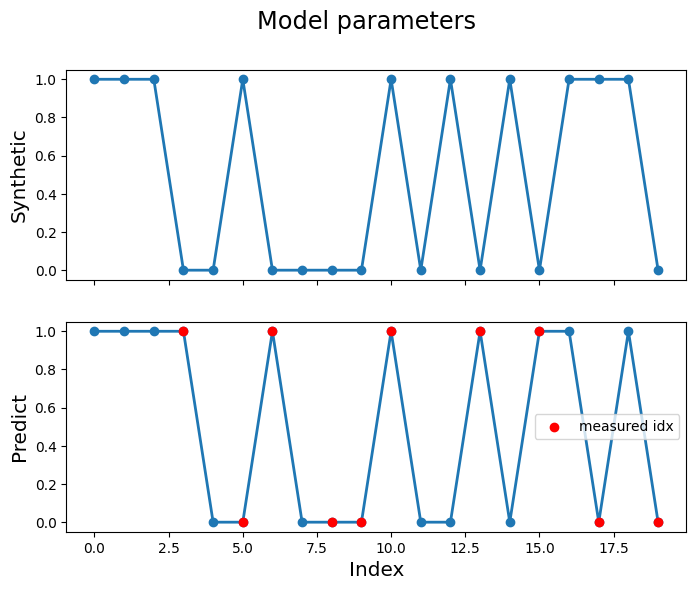

In [6]:
plot_params = {
    'axes.titlesize': 'x-large',
    'axes.labelsize': 'large',
    'font.size': 12,
    'figure.figsize': [8, 6],
    'figure.titlesize': 'x-large',
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'legend.fontsize': 'small',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
}
mpl.rcdefaults()  # add this line for the update to take effect
mpl.rcParams.update(plot_params)

fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(bin_model_params, marker="o")
ax[0].set_ylabel("Synthetic")

ax[1].plot(result["bin_model_params"], marker="o")
ax[1].scatter(
    measure_index,
    result["bin_model_params"][measure_index],
    marker="o", color="red", zorder=np.inf, label="measured idx"
)
ax[1].legend()
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Predict")

plt.suptitle("Model parameters")

plt.show()
mpl.rcdefaults()

## Compare predicted and observed responses

In [7]:
pred_resp = dwinv.utils.fwd_modeling(fwd_model, result["bin_model_params"], (low_param_value, high_param_value), resp_all2meas_func=resp_all2meas_func(measure_index))

with np.printoptions(precision=4, suppress=True):
    print(f"Predicted response =\n{pred_resp}\n")
    print(f"Observed response  =\n{obs_resp}\n")
    print(f"Residual sum of squares = {result['obj']:.8e}")

Predicted response =
[1.5152 2.4459 2.9004 3.8312 4.3074 4.7619 3.2381 2.2381 1.2619 0.2619]

Observed response  =
[1.5214 2.4429 2.8929 3.8357 4.3071 4.7571 3.2435 2.2344 1.2494 0.2643]

Residual sum of squares = 3.55456232e-04


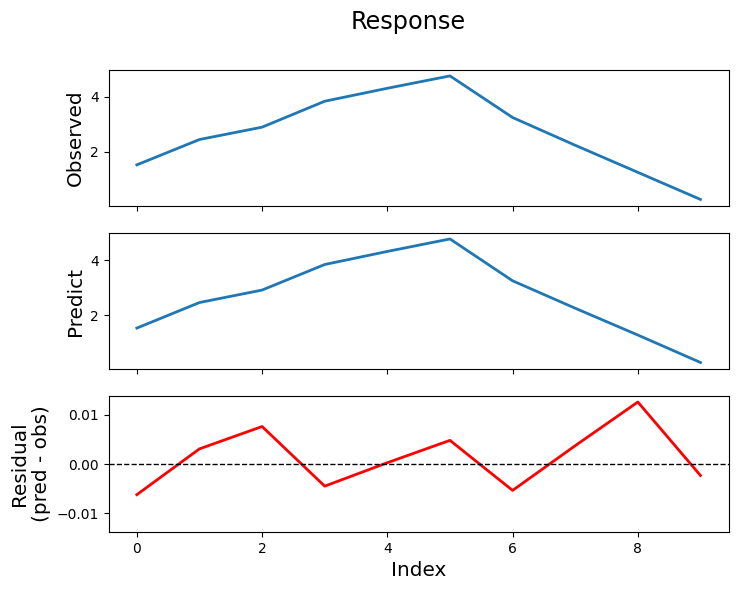

In [8]:
mpl.rcParams.update(plot_params)

fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(obs_resp)
ax[0].set_ylabel("Observed")

ax[1].plot(pred_resp)
ax[1].set_ylabel("Predict")

ax[2].plot(pred_resp - obs_resp, color="red")
ax[2].set_ylim(-1.1 * max(abs(pred_resp - obs_resp)), 1.1 * max(abs(pred_resp - obs_resp)))
ax[2].axhline(color="black", linestyle="--", linewidth=1)
ax[2].set_xlabel("Index")
ax[2].set_ylabel("Residual\n(pred - obs)")

plt.suptitle("Response")

plt.show()
mpl.rcdefaults()

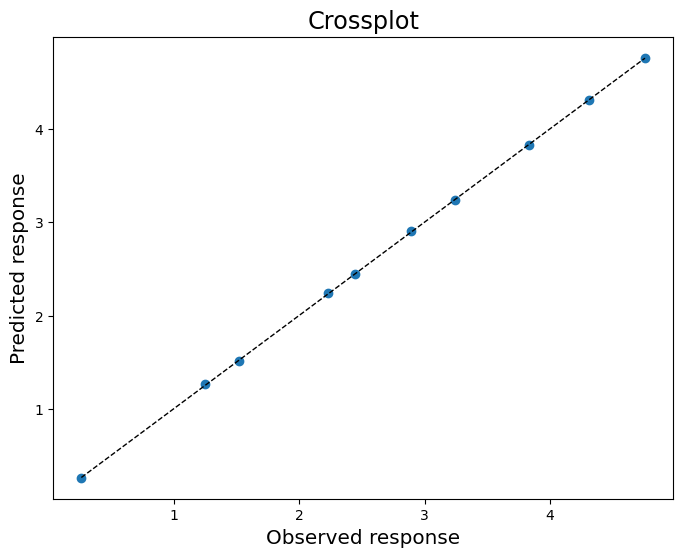

In [9]:
mpl.rcParams.update(plot_params)

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 6))
ax.scatter(obs_resp, pred_resp)
ax.plot([np.min(obs_resp), np.max(obs_resp)], [np.min(obs_resp), np.max(obs_resp)], color="black", linestyle="--", linewidth=1)
ax.set_xlabel("Observed response")
ax.set_ylabel("Predicted response")
ax.set_title("Crossplot")
plt.show()

mpl.rcdefaults()